# Making grid plots

The `gototile.grid.SkyGrid` class has a `plot()` method, which is a simple way to output a plot and has many formatting options.

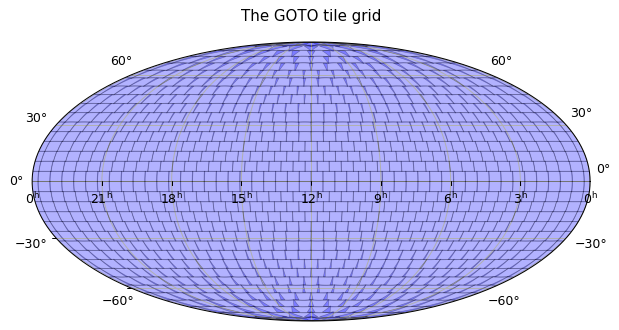

In [1]:
from gototile.grid import SkyGrid

grid = SkyGrid.from_name('GOTO')
grid.plot(title='The GOTO tile grid')

However, that's only good for a quick look. For more control there is the `SkyGrid.plot_tiles()` method, which takes already-existing axes and will plot the grid tiles onto them.

Here's a basic example:

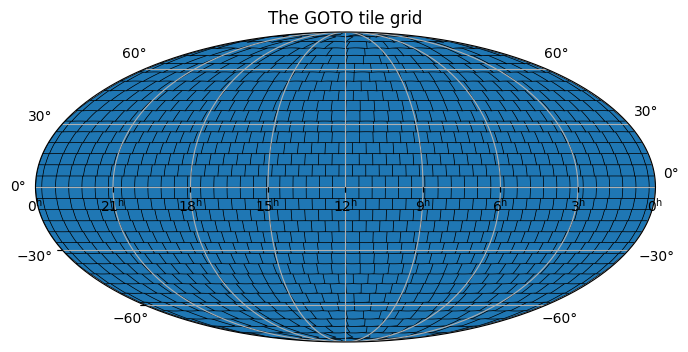

In [2]:
from matplotlib import pyplot as plt

# Create a blank figure
fig = plt.figure(figsize=(8, 6))

# Create the axes, using the astro Mollweide projection
# (see later for more projection options)
axes = fig.add_subplot(projection='astro hours mollweide')

# Add the tiles to the axes, using the default formatting
grid.plot_tiles(axes)

# Display the RA/Dec grid lines and add a title
axes.grid()
axes.set_title('The GOTO tile grid')

# Show the figure
plt.show()

The output in this case is similar, but plotting the tiles in this way adds a lot more options for customisation. The rest of this notebook shows some examples of what can be done.

---
## Example plots

### Plotting data arrays

A common case is that you have some data relating to each grid tile, for instance the number of times each tile was observed over a given period, and you want to colour the tiles in the plot using those values.

First we'll produce some random data:

In [3]:
import numpy as np

# Create some random data
rng = np.random.default_rng(1048)
data = rng.random(size=grid.ntiles)

# Set the values all tiles below 30 deg dec to None
data[grid.coords.dec.deg < -30] = None

Now we'll make a plot with the tiles coloured. Note any formatting arguments to the `plot_tiles` function after the axes gets passed to a `matplotlib.collections.PatchCollection` comprising the tile polygons, so look at the MPL documentation for the different options. Here we use the `array=` argument to pass an array of data, which is the same length as the number of tiles.

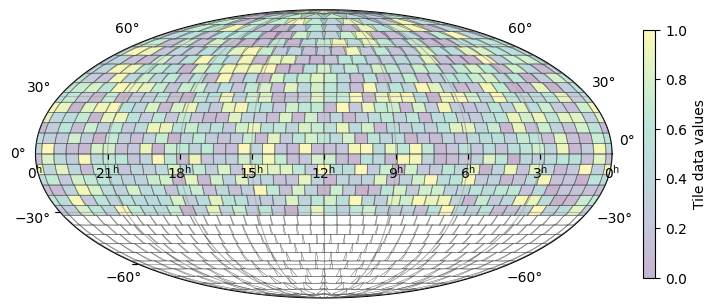

In [4]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(projection='astro hours mollweide')
axes.grid()

# Plot the tiles, using the `array` argument to apply to the tile fill colours
# Note we make the tiles slightly transparent to show the overlap
tiles = grid.plot_tiles(axes, array=data, ec='none', alpha=0.3, zorder=1)

# Plot the tile edges on top as solid lines on top
grid.plot_tiles(axes, fc='none', ec='0.3', lw=0.3, zorder=1.5)

# Add a colourbar
# (note you have to pass it the tile collection, and the limits are set on the tiles not the bar)
cbar = fig.colorbar(tiles, ax=axes, fraction=0.02, pad=0.05, label='Tile data values')
tiles.set_clim(0, 1)

plt.show()

### Setting formats for specific tiles

When using the `plot_tiles()` function you don't need to include every tile. Instead you can pass a list of tile names using the `tilenames=` argument, which can allow for more precise formatting.

Here we have some specific tiles we want to highlight, using their GOTO-tile IDs:

In [5]:
red_tiles = ['T0842', 'T1000', 'T0525']
blue_tiles = ['T1001', 'T0987', 'T0007']

Now let's plot the grid and highlight those tiles:

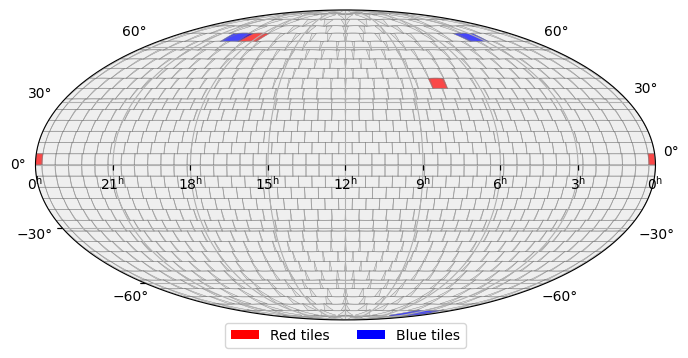

In [6]:
from matplotlib.patches import Patch

fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(projection='astro hours mollweide')
axes.grid()

# Plot only the tiles we want to highlight
grid.plot_tiles(axes, red_tiles, fc='red', ec='none', alpha=0.7, zorder=1.1)
grid.plot_tiles(axes, blue_tiles, fc='blue', ec='none', alpha=0.7, zorder=1.1)

# Now we'll add the rest of the grid in the background, and the edges over the top
grid.plot_tiles(axes, fc='0.8', ec='none', alpha=0.3, zorder=1)
grid.plot_tiles(axes, fc='none', ec='0.5', lw=0.3, zorder=1.2)

# Add a legend
# Note annoyingly you can't use the `label` argument to `plot_tiles` to set the legend labels,
# it doesn't get passed to the PatchCollection so you have to make your own Patches
red_legend = Patch(fc='red', label='Red tiles')
blue_legend = Patch(fc='blue', label='Blue tiles')
plt.legend(handles=[red_legend, blue_legend], loc='center', ncol=2, bbox_to_anchor=(0.5, -0.05))

plt.show()

Note that one of the highlighted tiles overlaps the RA=0 meridian, and both halves are coloured as you'd expect.

### Plotting coordinates and zoom plots

The astro axes used here are part of the LIGO skymap package, `ligo.skymap.plot`. The package is installed with GOTO-tile, mostly for plotting skymaps, but they are also very useful for the grids here. For more information see https://lscsoft.docs.ligo.org/ligo.skymap/plot/allsky.html.

The module provides multiple other projections, the most useful are `astro hours mollweide`, `astro zoom` and `astro globe`. We'll use `zoom` in this example and both `zoom` and `globe` in the next example.

Let's say we want to add some coordinates to our plot. The axes provided by the LIGO package are compatible with Astropy, so we can just create a SkyCoord.

In [7]:
from astropy.coordinates import SkyCoord

target = SkyCoord('20h00m 63d20m')

We might want to find which tiles on the GOTO grid those coordinates fall within. There's a helpful method on the `SkyGrid` class to do just that, which accounts for the fact that the grid tiles have a reasonable overlap (and in this case we want every tile the coordinates are within, not just the closest one).

Of course this target was picked carefully to fall within the overlap region of several tiles:

In [8]:
target_tiles = grid.get_tile(target, overlap=True)
target_tiles

['T0980', 'T1001', 'T1002']

Let's try plotting the grid zoomed in on that position, marking the coordinates and highlighting three tiles they are within.

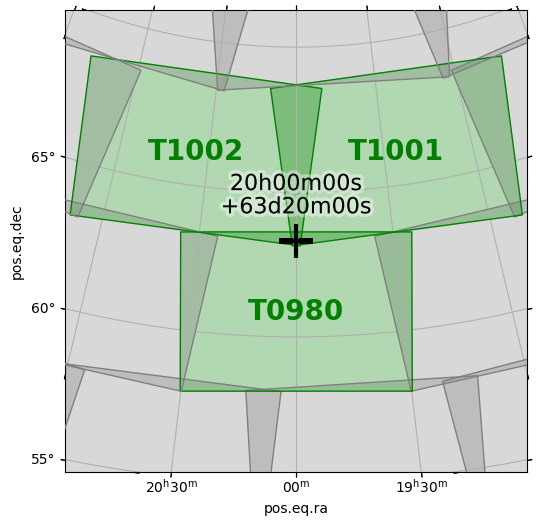

In [9]:
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(8, 6))

# Add axes using the `astro zoom` projection, centred on the coordinates.
axes = fig.add_subplot(projection='astro zoom', center=target, radius='8 deg')
axes.grid()

# Plot the coordinates on the grid
# Note we need to transform into the same projection as the axes,
# this is taken care of automatically in the `plot_tiles` function.
axes.scatter(
    target.ra.value,
    target.dec.value,
    s=600,
    c='black',
    marker='+',
    lw=3,
    zorder=2,
    transform=axes.get_transform('world'),
)

# Add a text label for the coordinates
# For clarity we add a path effect to make the text stand out
label = target.to_string('hmsdms').replace(' ', '\n') + '\n'
axes.text(
    target.ra.value,
    target.dec.value,
    label,
    fontsize=16,
    ha='center',
    va='bottom',
    zorder=2,
    path_effects=[pe.withStroke(linewidth=5, foreground='w', alpha=0.4)],
    transform=axes.get_transform('world'),
)

# Plot the tiles and edges, highlighting the tiles that contain the coordinates
# Instead of calling plot_tiles twice as in the previous example, we instead make
# an array of colours which sets the highlighted tiles to green and the rest to grey.
colours = ['green' if tilename in target_tiles else 'grey' for tilename in grid.tilenames]
grid.plot_tiles(axes, fc=colours, ec='none', alpha=0.3, zorder=1)
grid.plot_tiles(axes, fc='none', ec=colours, lw=1, zorder=1.5)

# Add text labels for the three highlighted tiles
for name in target_tiles:
    index = grid.tilenames.index(name)
    coord = grid.coords[index]
    plt.text(
        coord.ra.deg,
        coord.dec.deg,
        name,
        color='green',
        weight='bold',
        fontsize=20,
        ha='center',
        va='center',
        transform=axes.get_transform('world'),
    )

plt.show()

#### An aside...

You might have noticed by now that generally it's better to call the `plot_tiles` function twice, once for the tile fill colours and another for the outlines. This is the best way to show the overlapping regions, by making the filled tiles slightly transparent and having the outlines plotted over the top. Here's the same region as above, but if you didn't use this trick:

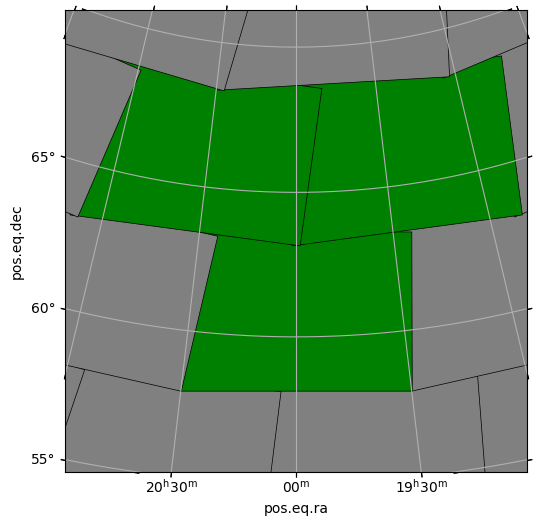

In [10]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(projection='astro zoom', center=target, radius='8 deg')
axes.grid()

# Just plot the tiles once, using the same `colours` array as above
grid.plot_tiles(axes, fc=colours)

plt.show()

As you can see the solid tiles overlap each other and it generally looks a lot uglier. You can get away with it when you're showing the full grid (the very first example of `plot_tiles` showing the full GOTO grid didn't add any transparency), but to get the full picture you'll want to show the overlapping regions. 

### Plotting tile statistics and globe plots

Here's a more complicated case study: plotting all the points on a HEALPix grid coloured by the number of tiles they fall within. I won't go into detail about how we calculate this, or how I had to hack the matplotlib colourbar, but instead I'll just show off the globe projection as well as another zoom looking at the north pole of the sphere.

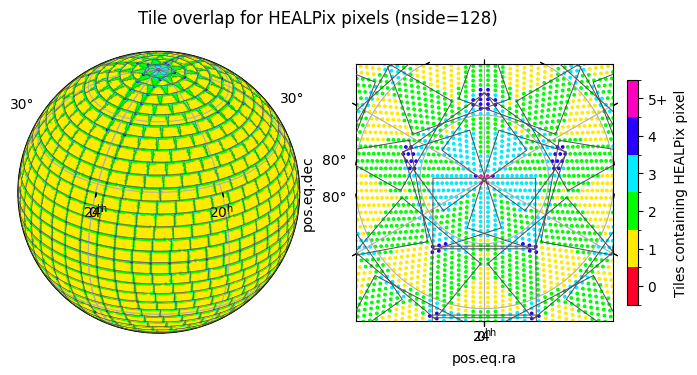

In [11]:
from matplotlib import colormaps
from matplotlib.colors import BoundaryNorm

from gototile.skymaptools import pix2coord

fig = plt.figure(figsize=(8, 6))

# Create the first subplot with a globe projection
axes = fig.add_subplot(121, projection='astro globe', center='22h 30d')
axes.grid()

# Plot just the tile edges
grid.plot_tiles(axes, fc='none', ec='0.3', lw=0.3, zorder=1.5)

# Get count statistics and the coordinates of each HEALPix pixel to plot
nside = 2**7
count = grid._get_pixel_count(nside)  # noqa: SLF001  # TODO: This is a private method
coords = pix2coord(nside, range(len(count)), nest=True)

# Create a new colour map
# [see https://stackoverflow.com/questions/14777066]
cmap = colormaps.get_cmap('gist_rainbow')
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom', cmaplist, cmap.N)

# Normalize to a maximum of 5
k = 5
norm = BoundaryNorm(np.linspace(0, k + 1, k + 2), cmap.N)

# Plot the points using the colourbar and normalisation
points = axes.scatter(
    coords.ra.deg,
    coords.dec.deg,
    s=1,
    c=count,
    cmap=cmap,
    norm=norm,
    zorder=0,
    transform=axes.get_transform('world'),
)

# Create the second subplot as a zoom plot looking at the pole
axes = fig.add_subplot(122, projection='astro zoom', center='0h 89d', radius='10 deg')
axes.grid()

# Plot the tiles and points again
grid.plot_tiles(axes, fc='none', ec='0.3', lw=0.7, zorder=1.5)
points = axes.scatter(
    coords.ra.deg,
    coords.dec.deg,
    s=3,
    c=count,
    cmap=cmap,
    norm=norm,
    zorder=0,
    transform=axes.get_transform('world'),
)

# Add a colorbar
cb = fig.colorbar(points, ax=axes, fraction=0.04, pad=0.05, label='Tiles containing HEALPix pixel')
tick_labels = np.arange(0, k + 1, 1)
tick_location = tick_labels + 0.5
tick_labels = [str(label) for label in tick_labels]
tick_labels[-1] = str(tick_labels[-1] + '+')
cb.set_ticks(tick_location)
cb.set_ticklabels(tick_labels)

# Add a supertitle over both subplots
fig.suptitle(f'Tile overlap for HEALPix pixels (nside={nside})', y=0.8)

plt.show()

In this case you can see that most of the grid is within one tile, while those points in the overlapping regions can be within two, three or four. Ideally you'd want to use a higher-resolution HEALPix grid for the plot on the right, but I thought it was interesting to show the individual points.

If you're wondering why some dots are coloured when they look like they are slightly outside the ede of the tile boundaries, that's because the dots are just the centres of the HEALPix pixels, and we consider a pixel to be "inside" a tile if any part of it is within the tile boundaries, not just the centre.



If you want the exact statistics you can use the `grid.get_stats()` method, which says that just over 70% of the grid is within one tile (the important thing is that there are no pixels within 0 tiles!):

In [12]:
grid.get_stats(nside)

in_tiles,npix,freq
int64,int64,float64
1,137786,70.08%
2,50342,25.61%
3,7762,3.95%
4,710,0.36%
5,8,0.00%


### Plotting skymaps

One of the reasons we have a grid is the framework to map skymaps onto, and see the probability contained within each tile. This is covered in the [skymaps notebook](skymaps.ipynb), but here's a quick example. First we need to download the skymap, and apply it to the grid.

In [13]:
from gototile.skymap import SkyMap

url = 'https://gracedb.ligo.org/api/superevents/S190521r/files/bayestar.fits.gz'
skymap = SkyMap.from_fits(url)
grid.apply_skymap(skymap)

array([6.30174138e-05, 3.18255403e-05, 6.99278022e-06, ...,
       9.06892007e-44, 5.17788340e-45, 1.51998807e-47])

Now we can just plot the tile contained probabilities on the grid, which just uses the `array=` argument used with the random data example.

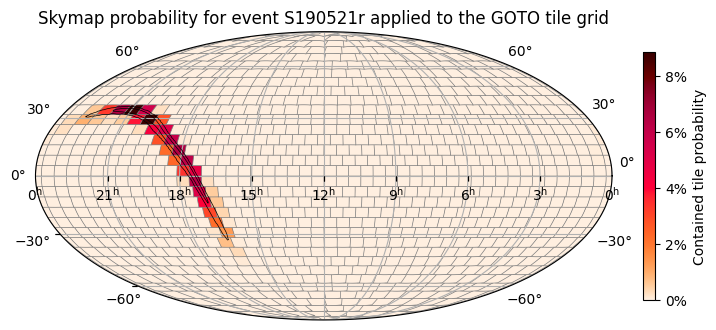

In [14]:
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(projection='astro hours mollweide')
axes.grid()

# Plot the tiles, with the data array given by the probability contained within each
# We also use the LIGO-preferred 'cylon' colormap
tiles = grid.plot_tiles(axes, array=grid.probs, cmap='cylon', ec='0.5')

# Overlay the skymap contours
skymap.plot_contours(axes)

# Add a title
axes.set_title('Skymap probability for event S190521r applied to the GOTO tile grid')

# And add a colourbar, formatting as a percentage
fig.colorbar(
    tiles,
    ax=axes,
    fraction=0.02,
    pad=0.05,
    format=lambda x, _: f'{x:.0%}',
    label='Contained tile probability',
)

plt.show()

The overlap between tiles be seen clearly with a more zoomed-in plot, which we can centre on the highest-probability tile:

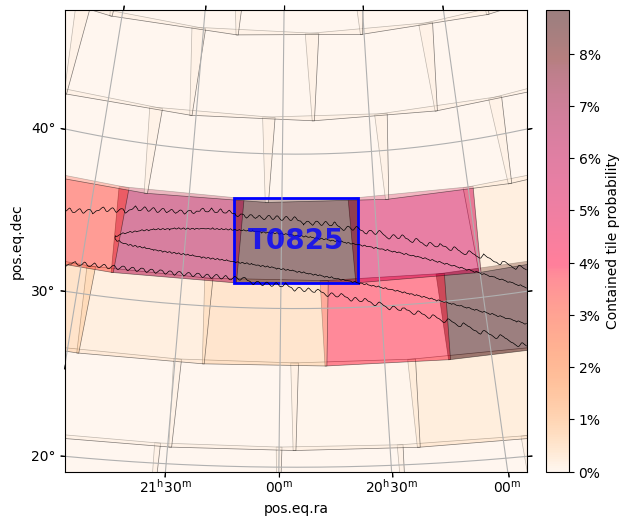

In [15]:
high_tile = np.argmax(grid.probs)
high_tile_name = grid.tilenames[high_tile]
high_tile_coord = grid.coords[high_tile]

fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(projection='astro zoom', center=high_tile_coord, radius='15 deg')
axes.grid()

# Plot the tiles and contours as before, but with some transparency to show the overlap
tiles = grid.plot_tiles(axes, array=grid.probs, cmap='cylon', alpha=0.5)
skymap.plot_contours(axes)

# Add a colorbar, with percentage formatting
fig.colorbar(
    tiles,
    ax=axes,
    fraction=0.04,
    pad=0.03,
    format=lambda x, _: f'{x:.0%}',
    label='Contained tile probability',
)

# Highlight the highest probability tile
grid.plot_tiles(axes, [high_tile_name], fc='none', ec='blue', lw=2)

# Add the tilename
axes.text(
    high_tile_coord.ra.deg,
    high_tile_coord.dec.deg,
    high_tile_name,
    ha='center',
    va='center',
    fontsize=20,
    weight='bold',
    color='blue',
    alpha=0.8,
    transform=axes.get_transform('world'),
)

plt.show()

Finally for a more complicated plotting example, we can combine a globe map and a zoom inset (taken from https://lscsoft.docs.ligo.org/ligo.skymap/plot/allsky.html#insets).

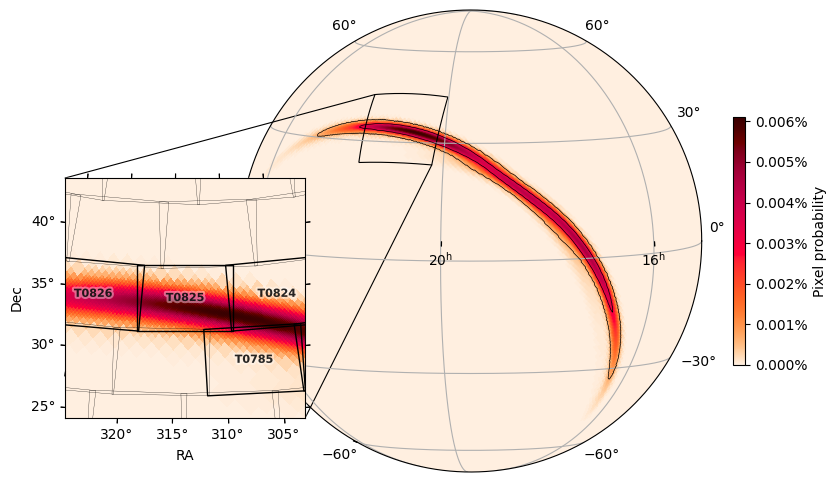

In [16]:
fig = plt.figure(figsize=(8, 6))

# Create the basic axis
axes = fig.add_subplot(projection='astro globe', center='19h30m 5d')
axes.grid()

# Plot the skymap data and contours
data, _ = skymap.plot_data(axes)
skymap.plot_contours(axes)

# Add a colour bar, formatting as a percentage
fig.colorbar(
    data,
    ax=axes,
    fraction=0.02,
    pad=0.05,
    format=lambda x, _: f'{x:.3%}',
    label='Pixel probability',
)

# Create the zoom plot on a different set of axes
axes_zoom = fig.add_subplot(
    [0.0, 0.2, 0.4, 0.4],
    projection='astro degrees zoom',
    center=high_tile_coord,
    radius='10 deg',
)

# Plot the skymap data again
skymap.plot_data(axes_zoom)

# Give names to any tiles within the 90% contour
top_tiles = np.array(grid.tilenames)[grid.contours < 0.9]
for tilename in top_tiles:
    tile_coord = grid.coords[grid.tilenames.index(tilename)]
    axes_zoom.text(
        tile_coord.ra.deg,
        tile_coord.dec.deg,
        tilename,
        ha='center',
        va='center',
        fontsize=8,
        weight='bold',
        color='black',
        alpha=0.8,
        clip_on=True,
        path_effects=[pe.withStroke(linewidth=3, foreground='white', alpha=0.4)],
        transform=axes_zoom.get_transform('world'),
    )

# Plot the tile outlines on top
grid.plot_tiles(
    axes_zoom,
    fc='none',
    ec='k',
    lw=[1 if t in top_tiles else 0.2 for t in grid.tilenames],
)

# Improve on the default axis labels
axes_zoom.set_xlabel('RA')
axes_zoom.set_ylabel('Dec')

# Connect the plot
axes.mark_inset_axes(axes_zoom)
axes.connect_inset_axes(axes_zoom, 'upper left')
axes.connect_inset_axes(axes_zoom, 'lower right')

plt.show()